# Начинаем всё сначала 2: возвращение к истокам

В предыдущих частях:
* RobustScaler и MinMaxScaler показали ухудшение результата. В случае RobustScaler использование приведения к нормальному распределению может быть некорректным, т.к. в нуле собирается большое количество точек, что могло быть не свойственно первоначальным данным. Нужно использовать другое шкалирование или вовсе от него отказаться.
* Почти каждый следующий submission хуже предыдущего (на картинке от нового к старому):

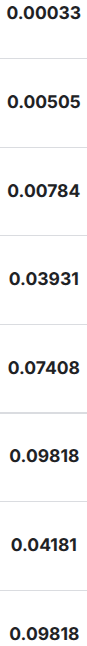

* Лучше всего себя показали PCA до 600 + Birch с random_state = 72 (Score 0.09818).
* Кажется, что при визуализации PCA показывает ситуацию более правильно, чем UMAP.

Что ещё можно попробовать:

* Проанализировать ненулевые числа.
* Посмотреть изменение доли объяснённой дисперсии у PCA при разных значениях n_components.
* Т.к. в датасете встречаются большие числа, то можно предположить, что L1-норма покажет себя лучше, чем евклидова.

Гипотезы:

* Нули это NaN'ы, т.е. их нужно заполнить, например, медианой или удалить.

## Загрузка данных

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster as sk_cluster
import sklearn.mixture as sk_mixture
import sklearn.preprocessing as sk_preproc
import sklearn.decomposition as sk_decomp

from sklearn import metrics
from scipy.spatial.distance import cdist
from tqdm import tqdm
import umap

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = sparse.load_npz('train.npz')
data.shape

(21000, 3049)

In [3]:
def save_pred(pred, filename):
    submission = pd.read_csv('sample_submission.csv', index_col='ID')
    submission['TARGET'] = pred
    submission.to_csv(filename)

## Предобработка

### Смотрим долю объясненной дисперсии

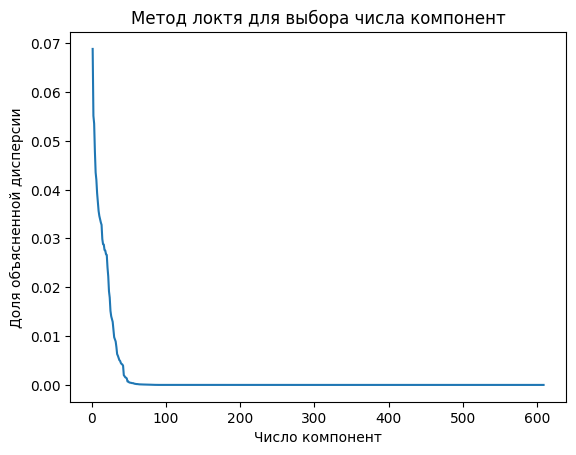

CPU times: user 10min 6s, sys: 1e+03 ms, total: 10min 7s
Wall time: 51.3 s


In [36]:
%%time
columns = data.shape[1]

pca = sk_decomp.PCA(n_components=columns//5, random_state=72)
pca.fit(data)

# Строим график объясненной дисперсии
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

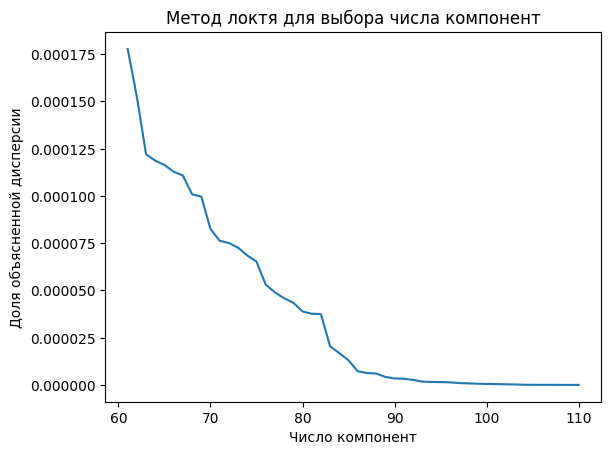

In [44]:
plt.plot(range(60 + 1, 110 + 1), explained_variance_ratio[60:110])
plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

Получаем, что при размерности 100 дисперсия почти полностью объясняется. Спроецируемся туда.

In [4]:
%%time
pca = sk_decomp.PCA(n_components=100, random_state=72)
data_100 = pca.fit_transform(data)

CPU times: user 32.6 s, sys: 48.5 ms, total: 32.6 s
Wall time: 5.62 s


Заодно возьмем двумерную проекцию для визуализации.

In [5]:
%%time
pca = sk_decomp.PCA(n_components=2, random_state=72)
data_2 = pca.fit_transform(data)

CPU times: user 1.91 s, sys: 4.71 ms, total: 1.91 s
Wall time: 1.25 s


<Axes: >

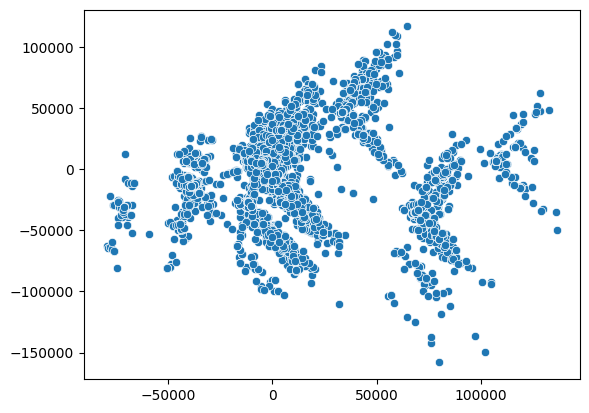

In [40]:
sns.scatterplot(x=data_2[:, 0], y=data_2[:, 1])

Я насчитал 8 кластеров.

### Анализируем

In [12]:
t = np.asarray(data.todense())

In [13]:
t = (t - np.min(t, axis=1, keepdims=True)) / (np.max(t, axis=1, keepdims=True) - np.min(t, axis=1, keepdims=True) + 1e-3)

In [22]:
example = np.asarray(data[0].todense())[0]

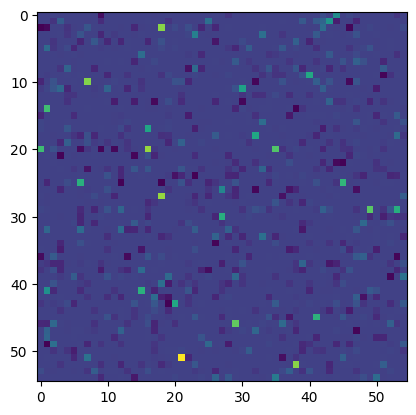

In [18]:
plt.imshow(t[:, :55**2].sum(axis=0).reshape(55, 55))

Похоже на небо. Может быть, это космические данные и кластеризация происходит по каким-нибудь созвездиям?

In [172]:
data.shape

(21000, 3049)

(array([1.000e+00, 6.000e+00, 1.000e+01, 1.300e+01, 4.100e+01, 5.900e+01,
        7.000e+01, 1.230e+02, 2.460e+02, 2.900e+02, 4.360e+02, 5.600e+02,
        9.710e+02, 9.020e+02, 1.007e+03, 1.272e+03, 1.776e+03, 1.398e+03,
        1.456e+03, 1.488e+03, 1.849e+03, 1.310e+03, 1.125e+03, 1.014e+03,
        1.081e+03, 6.100e+02, 5.100e+02, 4.290e+02, 3.850e+02, 1.650e+02,
        1.360e+02, 9.300e+01, 9.100e+01, 3.400e+01, 1.900e+01, 7.000e+00,
        7.000e+00, 6.000e+00, 3.000e+00, 1.000e+00]),
 array([496.  , 499.25, 502.5 , 505.75, 509.  , 512.25, 515.5 , 518.75,
        522.  , 525.25, 528.5 , 531.75, 535.  , 538.25, 541.5 , 544.75,
        548.  , 551.25, 554.5 , 557.75, 561.  , 564.25, 567.5 , 570.75,
        574.  , 577.25, 580.5 , 583.75, 587.  , 590.25, 593.5 , 596.75,
        600.  , 603.25, 606.5 , 609.75, 613.  , 616.25, 619.5 , 622.75,
        626.  ]),
 <BarContainer object of 40 artists>)

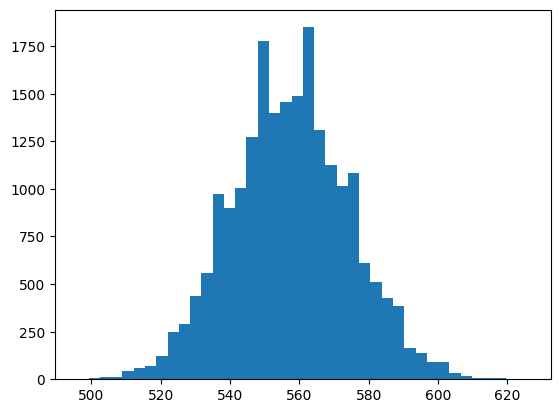

In [ ]:
plt.hist(np.asarray((data != 0.0).sum(axis=1))[:, 0], bins=40)

Похоже на нормальное распределение. Примерно одинаковое количество ненулевых признаков. Может быть нули вставлены просто так?

In [24]:
count_nonzero_row = np.asarray((data != 0.0).sum(axis=1))
min_count_nonzero_row = np.min(count_nonzero_row)
max_count_nonzero_row = np.max(count_nonzero_row)
print(min_count_nonzero_row, max_count_nonzero_row)

496 626


Попробуем собрать ненулевые данные.

In [ ]:
data_nonzero = np.zeros((data.shape[0], max_count_nonzero_row))

for i in range(data.shape[0]):
    r = np.asarray(data[i, :].todense())[0]
    r_nonzero = r[r != 0.0]
    # r_nonzero = np.sort(r_nonzero)
    data_nonzero[i, :len(r_nonzero)] = r_nonzero

In [174]:
data_nonzero[0]

array([-2.76893259e+00, -1.60514683e+00,  3.28380575e-01, -5.57459937e-01,
       -3.24525457e+00,  5.76868847e+00, -9.82038774e-01,  7.10633834e+00,
       -4.66372152e-01,  3.41858570e-04, -9.92795944e-01, -4.49258713e+00,
       -1.86976024e+00,  1.00000000e+00,  5.89466366e-01, -1.72341019e+00,
       -5.77579472e-01,  2.69540405e+00,  2.49689281e+00, -5.81282721e-01,
        6.09540249e+00, -1.92690154e+00, -4.23212874e+00,  7.41447809e-01,
        4.52918930e-01,  9.99830780e-01,  1.00000000e+00, -5.84519928e-01,
        8.28110730e-01, -1.70780936e+00,  8.23920423e+00, -6.34422544e-01,
        1.34299618e+00, -9.38445576e-01,  5.00000000e-01,  1.15767571e+00,
       -2.05254192e+00, -3.79775522e+00,  2.58098125e-01,  6.13743991e-01,
       -1.48824960e+00,  1.00000000e+00,  5.00000000e-01,  4.75886304e+00,
        8.47702556e-01, -5.30223539e-01, -9.52603227e-01, -1.67404998e+00,
        2.31861027e-01,  7.76314842e-01,  8.15006363e-01,  3.35601611e+00,
       -1.80067241e-01,  

In [159]:
pca = sk_decomp.PCA(n_components=2)
data_nonzero_2 = pca.fit_transform(data_nonzero)

<Axes: >

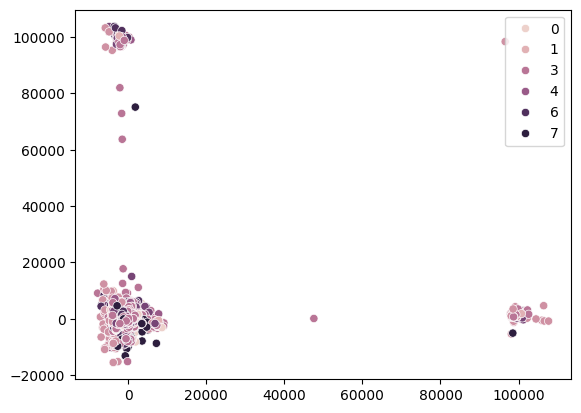

In [160]:
sns.scatterplot(x=data_nonzero_2[:, 0], y=data_nonzero_2[:, 1], hue=pred_kmeans)

<Axes: >

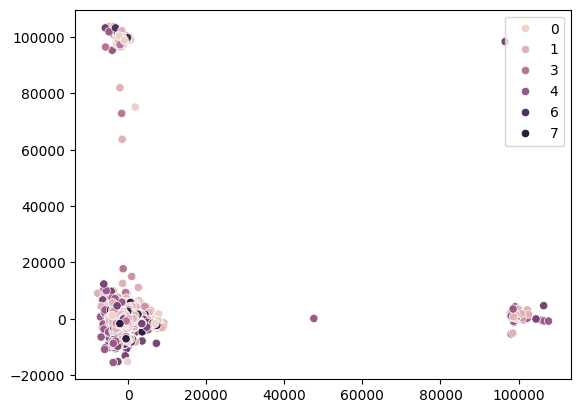

In [161]:
sns.scatterplot(x=data_nonzero_2[:, 0], y=data_nonzero_2[:, 1], hue=pred_birch)

Получается не очень. Кажется, иду не туда.

In [5]:
%%time
feat_uniq_count = defaultdict(list)
for i in range(data.shape[1]):
    column_data = np.array(data[:, i].todense())[:, 0]
    uniq = np.unique(column_data)
    count_uniq = len(uniq)
    feat_uniq_count[count_uniq].append(i)

CPU times: user 37.5 s, sys: 13.3 ms, total: 37.5 s
Wall time: 37.5 s


In [ ]:
len(feat_uniq_count[1])

616

Удаляем константные признаки:

In [ ]:
# def inv_ind(len, ind) -> np.ndarray:
#     res = np.arange(len)
#     res = res[~np.isin(res, ind)]
#     return res

# data = data[:, inv_ind(data.shape[1], feat_uniq_count[1])]

In [ ]:
# data.shape

(21000, 3049)

## Кластеризуем

### K-means + метод локтя

[Источник](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

In [53]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in tqdm(K):
    kmeanModel = sk_cluster.KMeans(n_clusters=k, random_state=72).fit(data_100)
    
    distortions.append(sum(np.min(cdist(data_100, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / data_100.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


Distortion values:
1 : 9169126856.163902
2 : 8702759950.115559
3 : 8392261222.707418
4 : 7851635508.225716
5 : 7569661350.804013
6 : 7445444590.78054
7 : 7077183618.64246
8 : 6753437452.850048
9 : 6398514720.574365
10 : 6359746054.971247
11 : 6246655275.838262
12 : 6018461069.736428
13 : 5867475191.228488
14 : 5647786367.078894
15 : 5466952622.152337
16 : 5281851092.995959
17 : 5220471622.262015
18 : 5000878273.728276
19 : 4875841452.170807


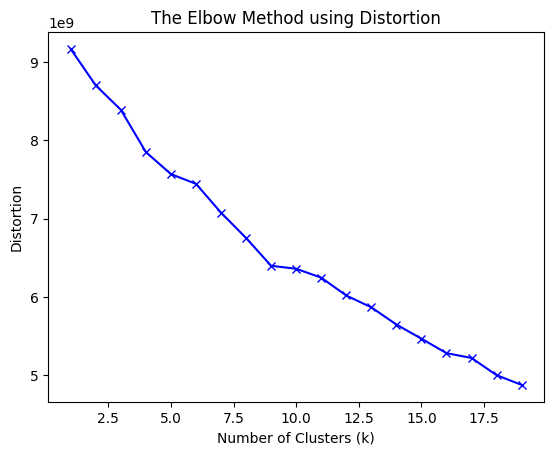

In [54]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

График не очень помогает определить количество кластеров. Попробуем 8 кластеров.

In [76]:
kmeans = sk_cluster.KMeans(n_clusters=8, random_state=14)
pred_kmeans = kmeans.fit_predict(data_100)

<Axes: >

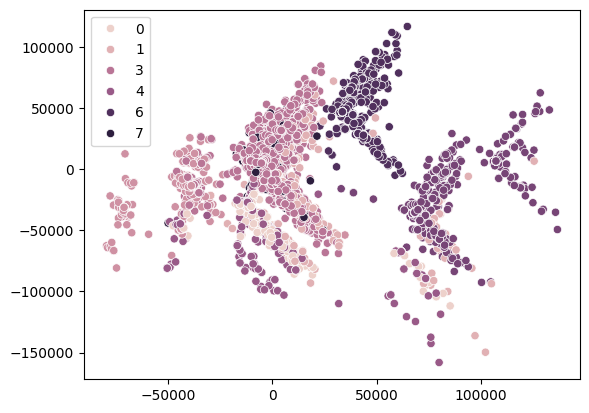

In [77]:
sns.scatterplot(x=data_2[:, 0], y=data_2[:, 1], hue=pred_kmeans)

Выглядит неплохо. Попробуем сдать.

In [95]:
save_pred(pred_kmeans, 'submission_new_kmeans.csv')

Score: -0.00600

Ура! Я достиг нуля!

## Немного подумаем (поправить)

* Руководствовать красивой картинкой нельзя.
* Следовательно, нужно использовать какие-нибудь критерии кластеризации.

Например, silhouette.

In [101]:
%%time
metrics.silhouette_score(data_100, pred_kmeans, metric='l1')

CPU times: user 42.3 s, sys: 1.17 s, total: 43.4 s
Wall time: 43.5 s


np.float64(0.357793324657239)

In [78]:
%%time
birch = sk_cluster.Birch(n_clusters=8)  # Показал пока себя самым лучшим
pred_birch = birch.fit_predict(data_100)

CPU times: user 50.8 s, sys: 48.3 s, total: 1min 39s
Wall time: 42.4 s


<Axes: >

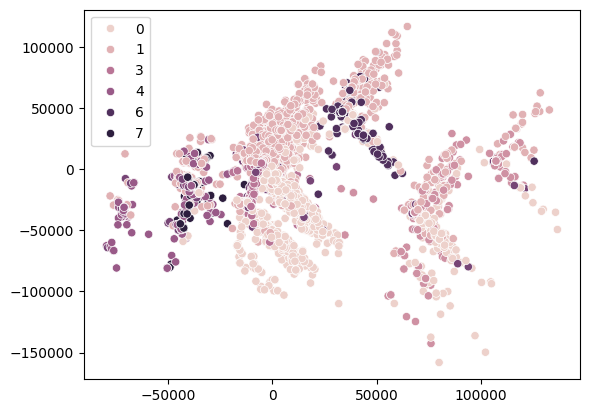

In [79]:
sns.scatterplot(x=data_2[:, 0], y=data_2[:, 1], hue=pred_birch)

K-means мне пока больше нравится. Хотя судя по Kaggle этот результат будет лучше.

In [100]:
%%time
metrics.silhouette_score(data_100, pred_birch, metric='l1')

CPU times: user 42.5 s, sys: 1.44 s, total: 44 s
Wall time: 44.2 s


np.float64(0.3495235289261024)

Тут даже хуже (при использовании евклидовой метрики результат аналогичный). Сравнить на исходных данных не предоставляется возможным из-за слишком большой размерности.

Таким образом, нужна или другая метрика или каким-то специальным образом предобрабатывать данные. Сначала посмотрим на различные метрики.

### Calinski-Harabasz Index

In [109]:
%%time
metrics.calinski_harabasz_score(np.asarray(data.todense()), pred_kmeans)

CPU times: user 317 ms, sys: 251 ms, total: 568 ms
Wall time: 566 ms


np.float64(1129.592138060988)

In [110]:
%%time
metrics.calinski_harabasz_score(np.asarray(data.todense()), pred_birch)

CPU times: user 268 ms, sys: 275 ms, total: 542 ms
Wall time: 539 ms


np.float64(846.6619732165981)

Не оно.

### Davies-Bouldin Index

In [111]:
%%time
metrics.davies_bouldin_score(np.asarray(data.todense()), pred_kmeans)

CPU times: user 2.79 s, sys: 227 ms, total: 3.02 s
Wall time: 467 ms


np.float64(1.3273018286122786)

In [112]:
%%time
metrics.davies_bouldin_score(np.asarray(data.todense()),  pred_birch)

CPU times: user 3.09 s, sys: 195 ms, total: 3.28 s
Wall time: 404 ms


np.float64(2.619347018615493)

Вполне может быть. Надо сравнить с другими вариантами.

In [119]:
# Score: 0.04181
pred_gauss = pd.read_csv('submission_gaus.csv')['TARGET'].to_numpy()

In [120]:
%%time
metrics.davies_bouldin_score(np.asarray(data.todense()),  pred_gauss)

CPU times: user 1.88 s, sys: 233 ms, total: 2.11 s
Wall time: 447 ms


np.float64(1.733508903850358)

Пока сходится.

In [121]:
# Score: 0.05598
pred_kmeans_old = pd.read_csv('submission_kmeans.csv')['TARGET'].to_numpy()
metrics.davies_bouldin_score(np.asarray(data.todense()),  pred_kmeans_old)

np.float64(3.0515057228546385)

Уже не очень. Но посмотрим ещё.

In [122]:
# Score: 0.07408
pred_birch_normal_umap = pd.read_csv('submission_birch_normal_umap.csv')['TARGET'].to_numpy()
metrics.davies_bouldin_score(np.asarray(data.todense()),  pred_birch_normal_umap)

np.float64(4.587153759439189)

Тоже не очень.

### Проверим гипотезу о том, что нули это NaN'ы

Если это так, то в случае удаления столбцов с нулями метрики станут показывать корреляцию с результатами на Kaggle.

In [6]:
ind = np.arange(data.shape[1])[np.asarray((data != 0.0).sum(axis=0))[0] == data.shape[0]]

In [7]:
data_del = data[:, ind]

In [9]:
kmeans = sk_cluster.KMeans(n_clusters=8, random_state=14)
pred_kmeans_del = kmeans.fit_predict(data_del)

<Axes: >

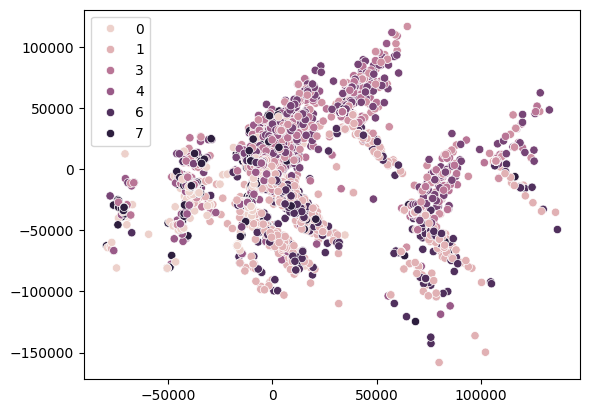

In [10]:
sns.scatterplot(x=data_2[:, 0], y=data_2[:, 1], hue=pred_kmeans_del)

In [44]:
metrics.davies_bouldin_score(np.asarray(data.todense()),  pred_kmeans_del)

np.float64(29.774218709227338)

Метрика аномально высокая.

Посмотрим на долю объясненной дисперсии, чтобы ещё сократить размерность.

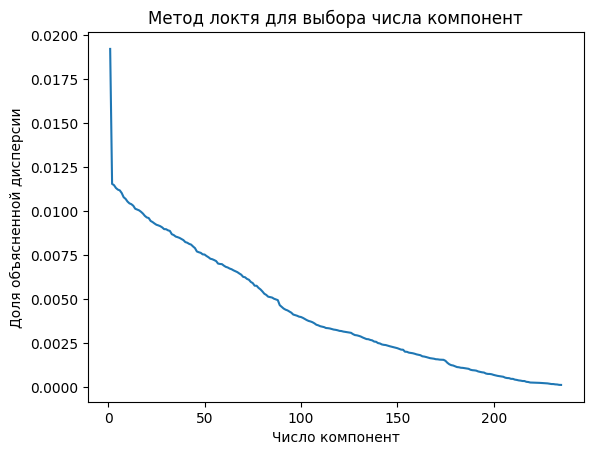

CPU times: user 12.5 s, sys: 41 ms, total: 12.6 s
Wall time: 3.21 s


In [69]:
%%time
columns = data_del.shape[1]

pca = sk_decomp.PCA(n_components=columns-1, random_state=72)
pca.fit(data_del)

# Строим график объясненной дисперсии
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

Лучше оставить всё. Всё равно мы и так много чего удалили.

In [11]:
pca = sk_decomp.PCA(n_components=2, random_state=72)
data_del_2 = pca.fit_transform(data_del)

<Axes: >

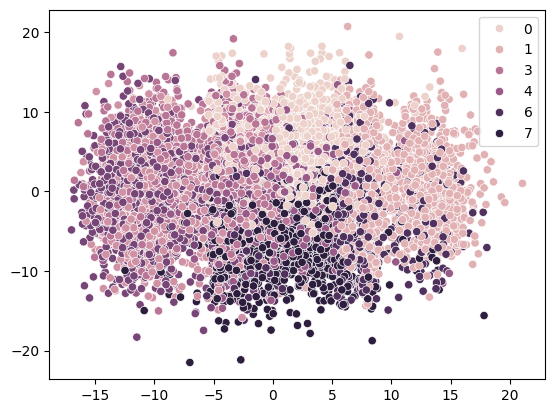

In [71]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_kmeans_del)

<Axes: >

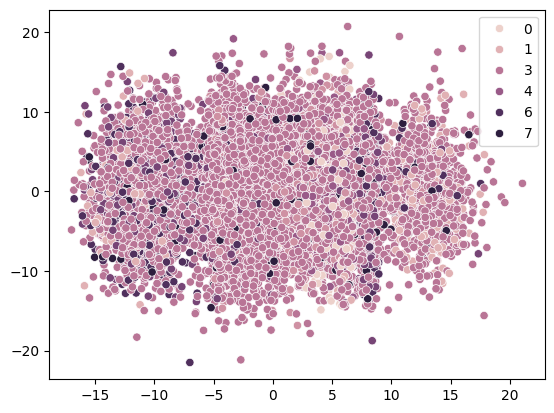

In [80]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_kmeans)

<Axes: >

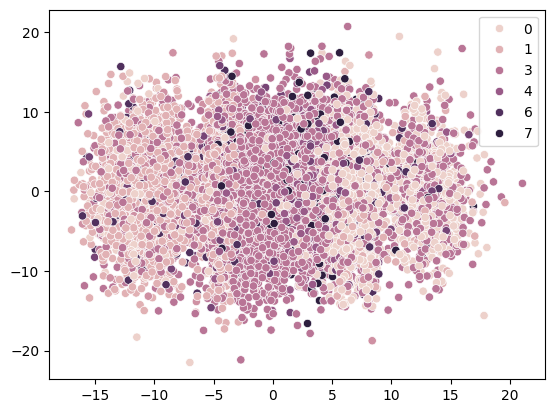

In [81]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_birch)

Ну, картинка с Birch выглядит более правильной.

In [89]:
metrics.davies_bouldin_score(np.asarray(data_del.todense()), pred_kmeans)

np.float64(36.258979881042194)

In [90]:
metrics.davies_bouldin_score(np.asarray(data_del.todense()), pred_birch)

np.float64(31.807657542007156)

In [ ]:
%%time
metrics.silhouette_score(data_del, pred_birch)

CPU times: user 16 s, sys: 45.6 s, total: 1min 1s
Wall time: 7.16 s


np.float64(-0.06702034478040712)

## Кластеризуем с удаленными данными

### K-means + метод локтя

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)

for k in tqdm(K):
    kmeanModel = sk_cluster.KMeans(n_clusters=k, random_state=14).fit(np.asarray(data_del.todense()))
    
    # distortions.append(sum(np.min(cdist(np.asarray(data_del.todense()), kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / data.shape[0])
    distortions.append(sum(np.min(cdist(np.asarray(data_del.todense()), kmeanModel.cluster_centers_, 'minkowski', p=1.), axis=1)**2) / data.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


Distortion values:
1 : 2180.7003600746216
2 : 2151.1978681551127
3 : 2139.6544165666874
4 : 2131.1115124838893
5 : 2124.9660391486136
6 : 2117.3194719959715
7 : 2112.776331764868
8 : 2108.121108643752
9 : 2104.224352090617
10 : 2101.7746838746125
11 : 2098.2276348234172
12 : 2094.4684692277197
13 : 2091.6582967808345
14 : 2090.3866657332787
15 : 2087.4910958509577
16 : 2084.854421367154
17 : 2083.090879723387
18 : 2080.739038404068
19 : 2079.6774685690857
20 : 2076.784537005939
21 : 2075.9286425634
22 : 2073.6500275793906
23 : 2071.690954305737
24 : 2070.6321358498285
25 : 2069.5724552355223
26 : 2068.067756480457
27 : 2066.121656310679
28 : 2065.0726261528007
29 : 2063.6848236041496


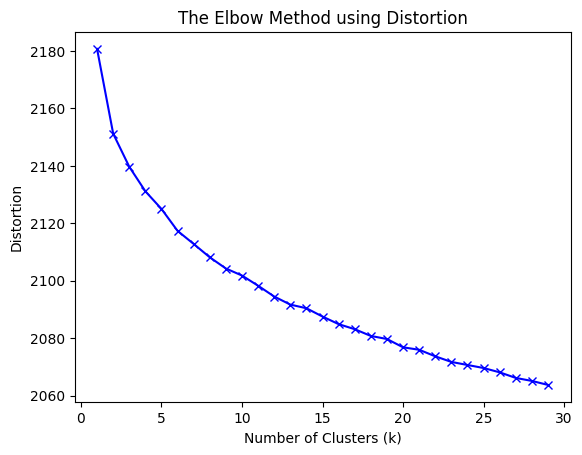

In [102]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Ничего сказать не получится.

### GaussianMixture

In [14]:
%%time
gm = sk_mixture.GaussianMixture(n_components=8, random_state=67)
pred_gm_del = gm.fit_predict(np.asarray(data_del.todense()))

CPU times: user 5min 30s, sys: 4.51 s, total: 5min 34s
Wall time: 22.4 s


<Axes: >

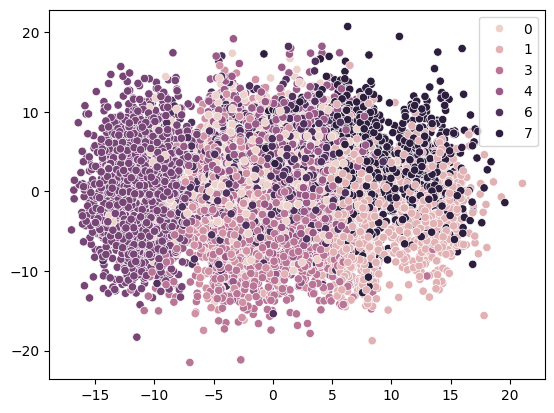

In [20]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_gm_del)

(array([2789., 2649., 1891., 2744., 2871., 2693., 2840., 2523.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

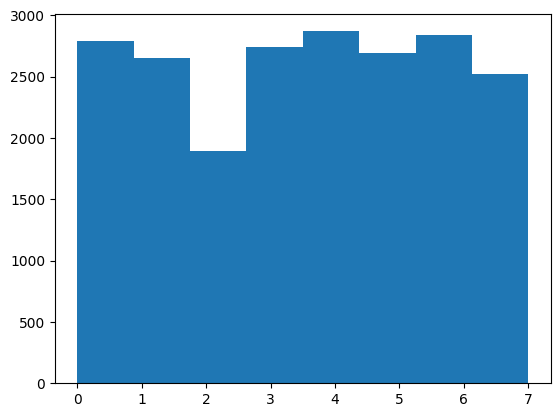

In [18]:
plt.hist(pred_gm_del, bins=8)

Выглядит неплохо. Попробуем.

In [19]:
save_pred(pred_gm_del, 'submission_gm_del.csv')

Score: 0.31921

Я в шоке! Наконец-то!

## Смотрим метрики

Похоже, что я в правильном направлении. Теперь посмотрим как ведут себя различные метрики, чтобы выбрать оптимальную.

Нужно не забыть, что можно ещё перебирать количество кластеров.

### Табличка с результатами

In [31]:
submissions = pd.DataFrame({
    'file':  ['submission_kmeans.csv', 'submission_birch.csv', 'submission_gaus.csv', 'submission_birch_normal.csv', 'submission_birch_normal_umap.csv', 'submission_birch_normal_umap_2.csv', 'submission_emis_robust_kmeans.csv', 'submission_emis_birch_mm.csv', 'submission_emis_birch_mm_100d.csv', 'submission_new_kmeans.csv', 'submission_gm_del.csv'],
    'score': [0.05598                , 0.09818               , 0.04181              , 0.09818                      , 0.07408                           , 0.03931                             , 0.00784                            , 0.00505                       , 0.00033                            , -0.00600                   , 0.31921]
})

In [34]:
submissions

,file,score
0,submission_kmeans.csv,0.05598
1,submission_birch.csv,0.09818
2,submission_gaus.csv,0.04181
3,submission_birch_normal.csv,0.09818
4,submission_birch_normal_umap.csv,0.07408
5,submission_birch_normal_umap_2.csv,0.03931
6,submission_emis_robust_kmeans.csv,0.00784
7,submission_emis_birch_mm.csv,0.00505
8,submission_emis_birch_mm_100d.csv,0.00033
9,submission_new_kmeans.csv,-0.00600


### Замеры

In [37]:
def check(submissions, data, metric):
    res = []
    for s in tqdm(submissions):
        sub_pred = pd.read_csv(s)['TARGET'].to_numpy()
        res.append(metric(data,  sub_pred))
    return res

In [40]:
davies = check(submissions['file'], np.asarray(data_del.todense()), metrics.davies_bouldin_score)

100%|██████████| 11/11 [00:00<00:00, 24.27it/s]


In [41]:
calinski = check(submissions['file'], np.asarray(data_del.todense()), metrics.calinski_harabasz_score)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 30.11it/s]


In [55]:
silhouette = check(submissions['file'], np.asarray(data_del.todense()), metrics.silhouette_score)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [01:33<00:00,  8.47s/it]


[Источник](https://www.geeksforgeeks.org/use-different-y-axes-on-the-left-and-right-of-a-matplotlib-plot/)

In [ ]:
def pair_plot(x, y1, y2):
    fig, ax1 = plt.subplots()

    ax1.tick_params(axis='x', rotation=90)

    color = 'tab:red'
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y1-axis', color=color)
    ax1.plot(x, y1, color = color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
 
    color = 'tab:green'
    ax2.set_ylabel('Y2-axis', color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.show()

#### Silhouette Coefficient

/tmp/ipykernel_137128/2977042814.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


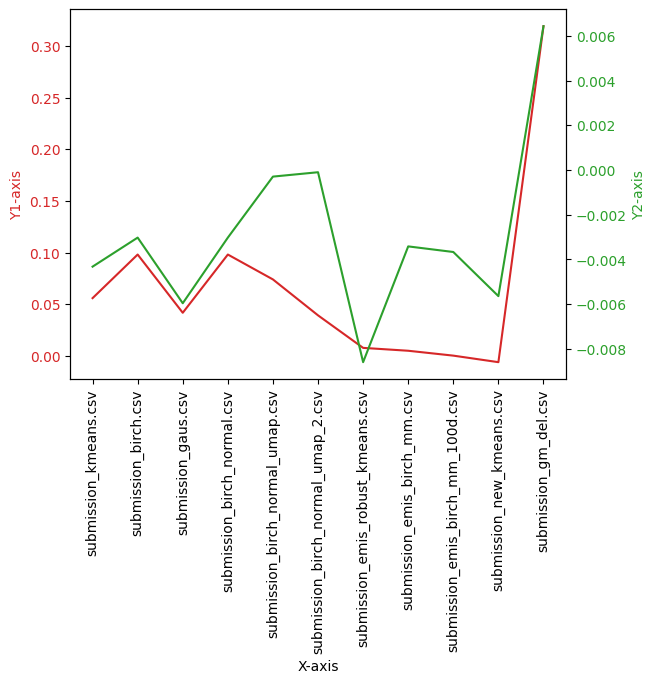

In [56]:
pair_plot(submissions['file'], submissions['score'], silhouette)

#### Calinski-Harabasz Index

/tmp/ipykernel_137128/2977042814.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


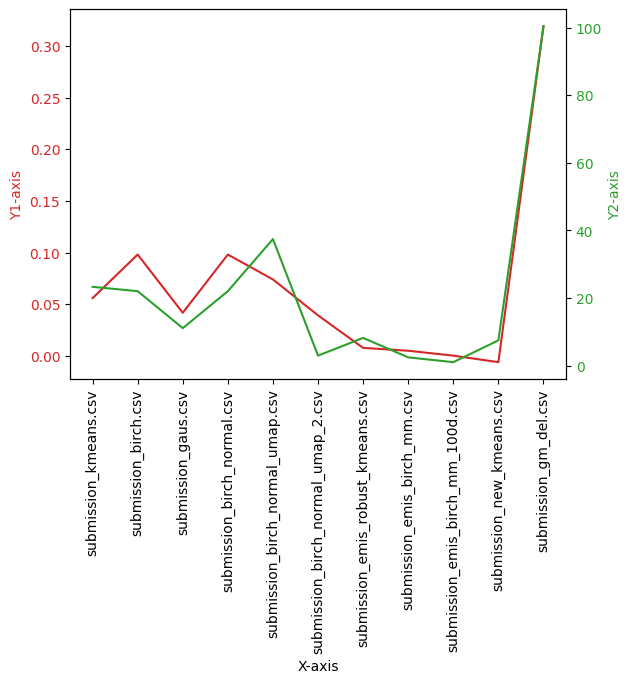

In [53]:
pair_plot(submissions['file'], submissions['score'], calinski)

#### Davies-Bouldin Index

/tmp/ipykernel_137128/2977042814.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


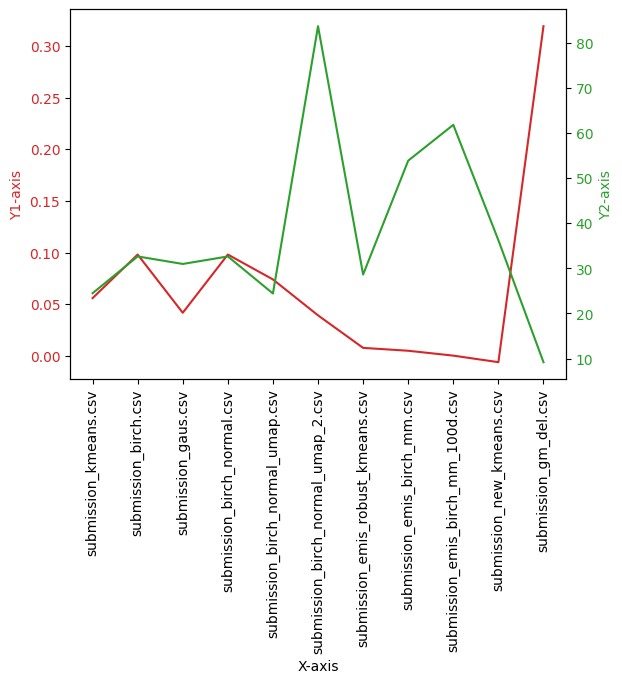

In [52]:
pair_plot(submissions['file'], submissions['score'], davies)

#### Выводы

Лучше всего подходит Calinski-Harabasz Index, т.к. Davies-Bouldin Index вообще ни о чем, а Silhouette Coefficient очень дорого считать.

## Снова кластеризуем

### Пробуем определить количество компонент

Будем это делать с помощью Gaussian Mixture и нашей метрики

In [58]:
K = range(2, 15, 2)
score = []

for k in tqdm(K):
    model = sk_mixture.GaussianMixture(n_components=k, random_state=67)
    pred_model = model.fit_predict(np.asarray(data_del.todense()))
    sc = metrics.calinski_harabasz_score(np.asarray(data_del.todense()), pred_model)
    score.append(sc)

100%|██████████| 7/7 [02:26<00:00, 20.97s/it]


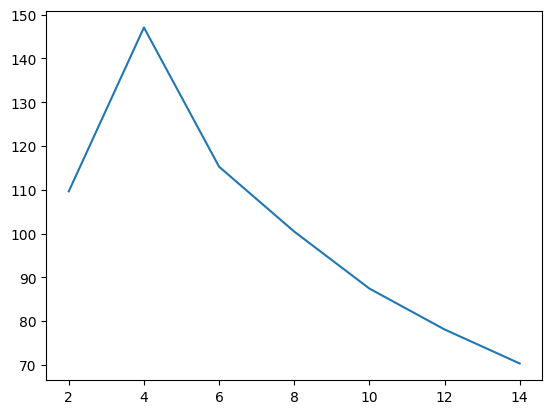

In [59]:
plt.plot(K, score)

In [60]:
K = range(2, 7)
score = []

for k in tqdm(K):
    model = sk_mixture.GaussianMixture(n_components=k, random_state=67)
    pred_model = model.fit_predict(np.asarray(data_del.todense()))
    sc = metrics.calinski_harabasz_score(np.asarray(data_del.todense()), pred_model)
    score.append(sc)

100%|██████████| 5/5 [01:55<00:00, 23.13s/it]


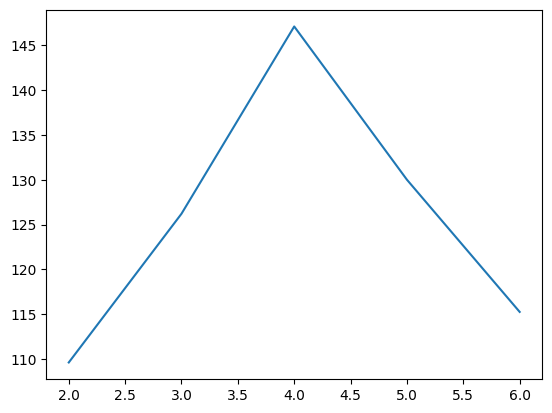

In [61]:
plt.plot(K, score)

Итого 4 кластера (по крайней мере, для этого метода).

### Определяем random_state

Попробуем перебирать случайные random_state для увеличения метрики. 

In [64]:
k = 20

state_score = {}

for i in tqdm(range(k)):
    state = np.random.randint(0, 200)
    model = sk_mixture.GaussianMixture(n_components=4, random_state=state)
    pred_model = model.fit_predict(np.asarray(data_del.todense()))
    sc = metrics.calinski_harabasz_score(np.asarray(data_del.todense()), pred_model)
    print(f"{state}: {sc}")
    state_score[state] = sc

  5%|▌         | 1/20 [00:27<08:41, 27.46s/it]

53: 146.34779589125532


 10%|█         | 2/20 [00:49<07:12, 24.04s/it]

178: 148.14067555156333


 15%|█▌        | 3/20 [01:13<06:50, 24.14s/it]

40: 145.87593335945724


 20%|██        | 4/20 [01:31<05:50, 21.90s/it]

159: 147.86360992850047


 25%|██▌       | 5/20 [01:53<05:24, 21.66s/it]

61: 146.05186199399924


 30%|███       | 6/20 [02:15<05:05, 21.81s/it]

1: 147.9335876986242


 35%|███▌      | 7/20 [02:37<04:47, 22.09s/it]

57: 147.31965705166945


 40%|████      | 8/20 [02:54<04:05, 20.44s/it]

32: 148.13433485988372


 45%|████▌     | 9/20 [03:16<03:49, 20.85s/it]

158: 146.7068236862685


 50%|█████     | 10/20 [03:39<03:36, 21.62s/it]

192: 147.75731823852902


 55%|█████▌    | 11/20 [03:56<03:01, 20.11s/it]

187: 148.15471713078148


 60%|██████    | 12/20 [04:15<02:37, 19.64s/it]

30: 147.17628904287733


 65%|██████▌   | 13/20 [04:35<02:18, 19.73s/it]

49: 147.47926497647248


 70%|███████   | 14/20 [04:52<01:53, 18.98s/it]

32: 148.13433485988372


 75%|███████▌  | 15/20 [05:12<01:36, 19.27s/it]

99: 147.7851637462755


 80%|████████  | 16/20 [05:30<01:16, 19.01s/it]

63: 148.49279667601485


 85%|████████▌ | 17/20 [05:49<00:57, 19.05s/it]

125: 148.0003190505493


 90%|█████████ | 18/20 [06:11<00:39, 19.85s/it]

158: 146.7068236862685


 95%|█████████▌| 19/20 [06:31<00:20, 20.02s/it]

123: 148.59898547519862


100%|██████████| 20/20 [06:56<00:00, 20.84s/it]

86: 146.92157418185292


In [67]:
max(state_score.items(), key=lambda t: t[1])

(123, np.float64(148.59898547519862))

Результаты не сильно отличаются, но выберем 128.

### Делаем итоговое предсказание

In [68]:
%%time
gm = sk_mixture.GaussianMixture(n_components=4, random_state=128)
pred_gm_del_opt = gm.fit_predict(np.asarray(data_del.todense()))

CPU times: user 7min 11s, sys: 5.18 s, total: 7min 16s
Wall time: 29.5 s


<Axes: >

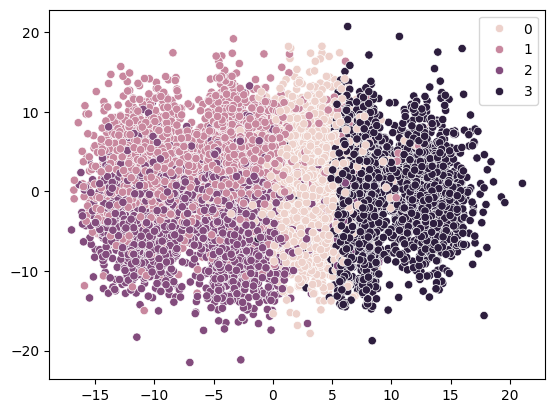

In [ ]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_gm_del_opt)

(array([4522.,    0.,    0., 5820.,    0.,    0., 5712.,    0.,    0.,
        4946.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

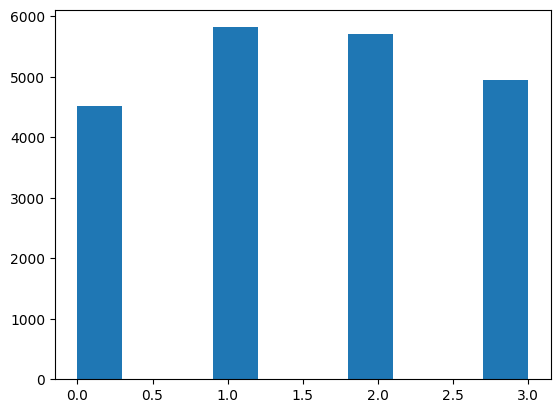

In [72]:
plt.hist(pred_gm_del_opt)

Выборка опять получилась сбалансированной.

Проверяем:

In [71]:
save_pred(pred_gm_del_opt, 'submission_gm_del_opt.csv')

Score: 0.36017

Получше, но не сильно.

## Некоторые итоги

* Наконец-то получилось преодолеть порог simple.
* Похоже, что Calinski-Harabasz Index действительно показывает действительность (хотя может быть просто совпало).
* Похоже, что нули действительно обозначают NaN.
* GaussianMixture неплохо себя показал.

Что ещё можно попробовать:
* Не удалять все столбцы с нулями. Если нулей немного, то можно заполнять средним значением.
* Другие методы. Для них можно перебирать количество компонент и другие параметры.
* UMAP.

## Последний этап (больше попыток не будет)

In [ ]:
%%time
hdbscan = sk_cluster.HDBSCAN()
pred_hdbscan_del = hdbscan.fit_predict(data_del)

In [ ]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_hdbscan_del)